# Introduction

For the project, the group decided to implement a convolutional neural network in order to use it for recognizing handwritten digits. Before this could be achieved, the group had to invest time to get a better grasp of understanding how CNN works. 
In order to achieve that, a simpler neural network had to be built, which would serve as a foundation for creating the full CNN model.

The document will introduce the groups approach for building the CNN model. Firstly, the document will introduce how was the simple neural network built and showcase the initial results for recognizing digits.
Secondly, the document will explain how was the CNN model built and explain whether it is better than a simple neural network by comparing the results.

The document will also present how the group experimented with different attributes such as learning rate, momentum and random seed numbers and explain what effect do they have for the model.
Lastly, the document will also discuss whether using a neural network for handwritten digit recognition had any ethical impact in the real world.

# Neural network

The implementation of our neural network was inspired by a third-party source [1] which introduces how to implement a neural network to people who are new to the topic. Therefore, certain variables such as the batch sizes, the learning rate as well as the momentum were kept the same. This was due to the fact that even when we slightly changed the numbers, it did not have an impact on the final results.

The following section will introduce our implementation of the neural network. The section will also cover the results such as how well did the network learn about the dataset and was it able to accurately predict the digits.

First, we import all the libraries which are used for importing the dataset and creating the network.

In [28]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from IPython.display import HTML, Image, display
from time import time

Then, we create static variables that will be used later. These variables consists of values such as the rate at which the network learns from the data.

In [30]:
# Number of times to rerun the training dataset
epochs = 50

# How many images to feed through the network each time
batch_size_train = 64
batch_size_test = 1000

# Step size for gradiant decent
learning_rate = 0.01

# Gives the network a chance to jump out of a local minima
momentum = 0.5

# Use a constant seed for randomness so that reruns becomes predictable
random_seed = 1
torch.manual_seed(random_seed)

torch.backends.cudnn.enabled = False

The following code blocks provides the data set with handwritten digits. It converts the images into Pytorch tensors and normalizes the pixels into the range 0 to 1.

In [4]:
training_set = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                             torchvision.transforms.Normalize((0.5,), (0.5,))])),batch_size=batch_size_train, shuffle=True)

test_set = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.5,), (0.5,))])),batch_size=batch_size_test, shuffle=True)

The following line of code simply outputs the structure of the data. The output here shows that each batch in the training data contains 64 images and that each image has 28x28 pixels dimension.

In [5]:
examples = enumerate(training_set)
_, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([64, 1, 28, 28])

The code block below plots different numbers from the dataset to show numbers and different ways people wrote them down. Each image has a ground truth which simply means what number does the image represent. This is a way to show that everyone has a different handwriting and the network should be capable of recognizing most of the numbers.

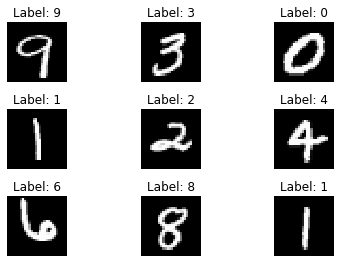

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Label: {}".format(example_targets[i]))
    plt.axis('off')

The following function simply creates and returns a model that contains 3 layers: a 28x28 input layer, a hidden layer of 50 nodes and an output layer of size 10. The LogSoftmax is for normalizing the output vector to a range between 0 and 1.

In [7]:
def create_model():
    return nn.Sequential(
        nn.Linear(28 * 28, 50),
        nn.ReLU(),
        nn.Linear(50, 10),
        nn.LogSoftmax(1)
    )

The following code block trains the network with the handwritten digit data (training_set). It iterates over an n amount of epochs. It also iterates over each batch from the training_set. At each iteration, it adjusts the weights as well as calculating the loss. This allows us to see how accurate is the prediction of each batch. The accuracy is stored in an array which helps to plot the training process of the network.

In [38]:
def train_model(model):
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    total = 0
    nr_correct = 0

    accuracy = []
    for n in range(0, epochs):
        
        total_train_loss_neural = 0
        
        for (batch_index, (images, labels)) in enumerate(training_set):
            images = images.view(images.shape[0], -1)
            result = model(images)

            optimizer.zero_grad()

            loss = criterion(result, labels)
            total_train_loss_neural += loss.item()
            loss.backward()

            optimizer.step()

            _, predictions = torch.max(result, 1)
            total = images.size(0)
            nr_correct = torch.sum(predictions == labels).item()
            network_accuracy = nr_correct / total
            accuracy.append(nr_correct / total)
        
        total_train_loss_neural = total_train_loss_neural / (itr + 1)
        print('\nEpoch: {}/{}, Train Loss: {:.8f}, Training Accuracy: {:.8f}'.format(n + 1, no_epochs, total_train_loss_neural, network_accuracy))
    
    return accuracy

The purpose of this function create a test model which can be used to compare to the training model. It is used to check if the model generalized to the other data.

In [9]:
def test_model(model, test_set):
    total = 0
    nr_correct = 0
    
    for images, labels in test_set:
        images = images.view(images.shape[0], -1)
        result = model(images)
        
        _, predictions = torch.max(result, 1)
        total += images.size(0)
        nr_correct += torch.sum(predictions == labels).item()
                
    return nr_correct / total

The function within the codeblock below uses the information obtained from the training to plot the rate at which the network learns about the data. The plot contains the amount of training batches and the accuracy of the model during the training.

In [10]:
def plot_learning_rate(batch_accuracies):
    fig, ax = plt.subplots()
    ax.plot(
        range(0, len(batch_accuracies)), 
        batch_accuracies
    )

    ax.set_ylim((0, 1))
    ax.set(
        xlabel='training batches', 
        ylabel='accuracy',
        title='Model accuracy during training'
    )

    plt.show()

The following lines of code simply calls out the previously mentioned functions in order to create the model, train it and plot it the information about its accuracy during training.

In [ ]:
model = create_model()
accuracy = train_model(model)
plot_learning_rate(accuracy)


Epoch: 1/50, Train Loss: 17.36379699, Training Accuracy: 0.81250000

Epoch: 2/50, Train Loss: 9.31734903, Training Accuracy: 0.87500000

Epoch: 3/50, Train Loss: 8.08171763, Training Accuracy: 0.93750000


The function below plots a the accuracy of the networks prediction of a single handwritten number from the test_set.
The generated graph displays all possible 10 numbers and shows which are the closest numbers that match the handwritten number.

In [12]:
def plot_image_classification(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray', interpolation='none')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

It's time to see how well our network generalize to the test set.

In [13]:
test_model(model, test_set)

0.9134

The following code block fetches images and labels of the handwritten numbers. It fetches a single number from test_set and prints it out as an image to allow the user to know which handwritten number the network tried to predict.
Together with the previously mentioned function, this allows to show the number that the network tries to guess together with the graph that displays the network's accuracy.

Predicted Digit:  1
Original Label:  1


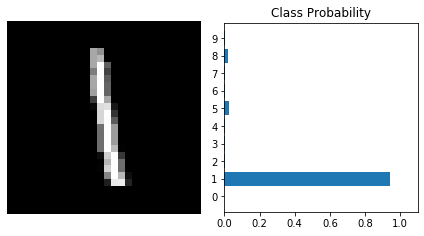

In [14]:
images, labels = next(iter(test_set))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit: ", probab.index(max(probab)))
print("Original Label: ", labels[0].item())
plot_image_classification(img.view(1, 28, 28), ps)

In [15]:
correct_count, all_count = 0, 0
predicted_labels = []
actual_labels = []
for images,labels in test_set:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img)

        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        
        predicted_labels.append(pred_label)
        actual_labels.append(true_label)
        
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print(correct_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000
9134

Model Accuracy = 0.9134


# Confusion matrix

In order to evaluate the accuracy of our neural network, we decided to construct a confusion matrix. The purpose of it is to help the group understand which certain numbers from the digit dataset provided the most issues. This way, it helped us understand if certain digits made the network doubt on determining the exact number it is currently looking at. With these results, it would be possible to adjust the network to reduce the odds of these problems occuring.

The way the matrix works is that it uses the data from the testing function (predicted_labels, actual_labels). Because the testing function goes over each number and informs whether it recognized the number or not, this allows the matrix to sort this information and illustrate it in a more understandable way.

In [16]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
           
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # print(cm)

    fig, ax = plt.subplots(figsize = (10, 10))
    im = ax.imshow(cm,cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    x_classes = classes 
    classes.reverse()
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),       
           xticklabels=x_classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right")

    # Loop over data dimensions and create text annotations.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color="white" if cm[i, j] > 500 else "black"
            ax.text(j, i, format(cm[i, j]), ha="center", va="center", color=color)
    
    ax.set_xticks(np.arange(cm.shape[1]+1)-.5)
    ax.set_yticks(np.arange(cm.shape[0]+1)-.5)
    plt.show()


The following code block labels the numbers we want to illustrate, ranging from 0 to 9. It also calls out the function defined above with the data collected from the training function.

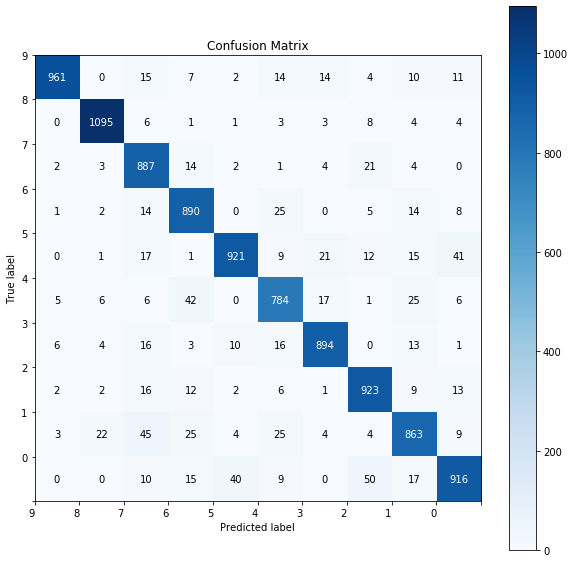

In [17]:
label_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,]

plot_confusion_matrix(predicted_labels, actual_labels, label_list)

# Our custom CNN

# External CNN

After creating our own CNN model and evaluating both the training accuracy and testing accuracy, the next step was to find an external CNN model. This would be done to further evaluate our custom model to determine if it is performing the same or even better than previously existing CNN models.

A CNN model was discovered on [2] which both explains how each parts of the network work as well as provide the full source code for other people to test it.

This section will quickly go over the parts of the external CNN model and explain whether this model is better than our own custome one.

The following code block imports the same dataset of handwritten digits as the previous neural network. However, it splits the data into 3 different arrays, train_dataloader, val_dataloader and test_dataloader. The first array contains 60000 training images for the network to learn from. The second array is used to validate the network to determine whether the network is still providing the correct results, to determine if it is underfitting or overfitting. The third array is used to further test and validate the results once more for correctness.

In [18]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

mnist_valset, mnist_testset = torch.utils.data.random_split(mnist_testset, [int(0.1 * len(mnist_testset)), int(0.9 * len(mnist_testset))])

train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))

Training dataset size:  60000
Validation dataset size:  1000
Testing dataset size:  9000


This code block below simply prints out the first images in the the training dataset to show what data the network is working with. The color is different here than our dataset, because we adjusted our code to show the images in their true color instead of Python automatically showing them with different colors.

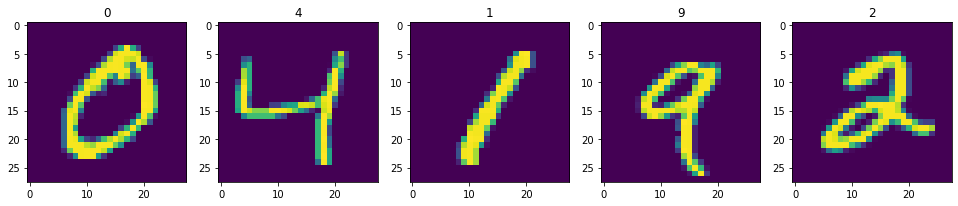

In [19]:
# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img = transforms.ToPILImage(mode='L')(mnist_trainset[i][0])
    fig.add_subplot(1, 6, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img)
plt.show()

The following code block creates the CNN model. It consists of 2 convolutional layers, 1 max pooling layer, 2 hidden layers and an output layer. It also creates a feed-forward function that is used when sending data to the model.

In [20]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

The code below simply creates a new instance of the model, defines the criterion and the optimizer functions. It also initializes how many epochs will it iterate over as well as define variables that will be used for measuring the loss when training and validating the data.

In [26]:
model = Model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

no_epochs = 50
train_loss = list()
val_loss = list()
best_val_loss = 1

The code block below is the core part of the external CNN. Here a for loop iterates over an n amount of epochs. At each iteration, the network is trained with the training dataset. Afterwards, the CNN is validated with more data using a separate validation dataset. At each iteration, the loop prints out the training and validation loss and the measured accuracy.

In [29]:
time0 = time()

for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    
    # training
    for itr, (image, label) in enumerate(train_dataloader):

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    # validation
    model.eval()
    total = 0
    for itr, (image, label) in enumerate(val_dataloader):

        pred = model(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(mnist_valset)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")
print("\nTraining Time (in minutes) =",(time()-time0)/60)


Epoch: 1/50, Train Loss: 0.27321254, Val Loss: 0.06700131, Val Accuracy: 0.97500000
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.06700131

Epoch: 2/50, Train Loss: 0.09407640, Val Loss: 0.04719447, Val Accuracy: 0.98500000
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.04719447

Epoch: 3/50, Train Loss: 0.07046799, Val Loss: 0.03764274, Val Accuracy: 0.98500000
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.03764274

Epoch: 4/50, Train Loss: 0.05965109, Val Loss: 0.03525258, Val Accuracy: 0.98500000
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.03525258

Epoch: 5/50, Train Loss: 0.04944969, Val Loss: 0.02805087, Val Accuracy: 0.99000000
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.02805087

Epoch: 6/50, Train Loss: 0.04147964, Val Loss: 0.03104765, Val Accuracy: 0.99000000

Epoch: 7/50, Train Loss: 0.03555672, Val Loss: 0.02845882, Val Accuracy: 0.98700000

Epoc

The following code block prints out the training and validation loss of the CNN.

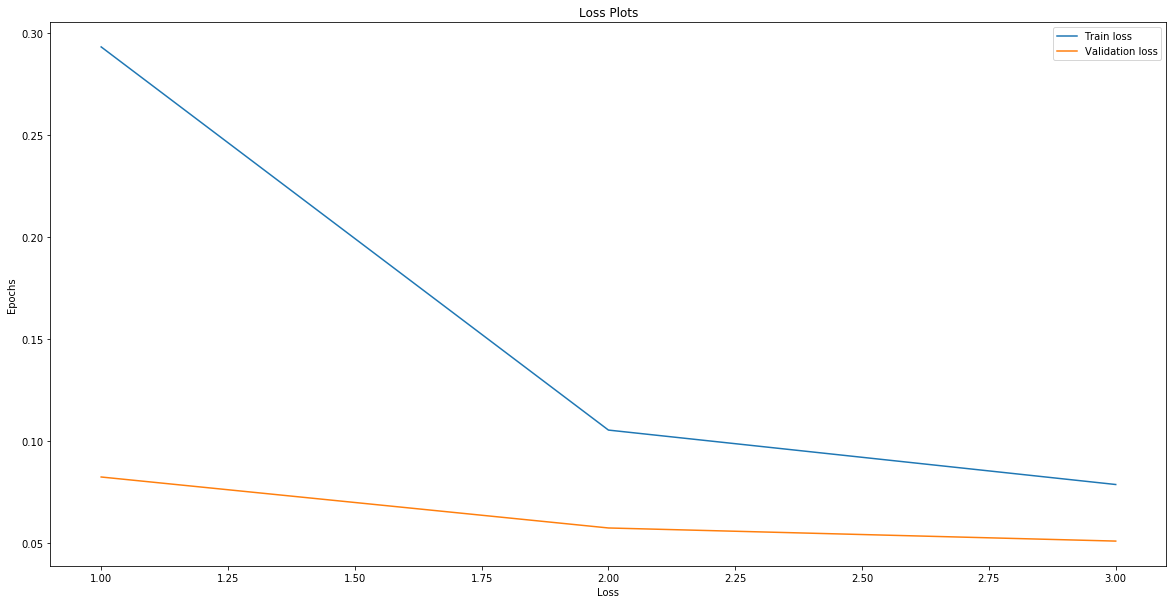

In [23]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

Finally, the following code block runs over a testing dataset, that consists of 1000 images. This is used to finalize the results and determine if the trained network provided accurate results.

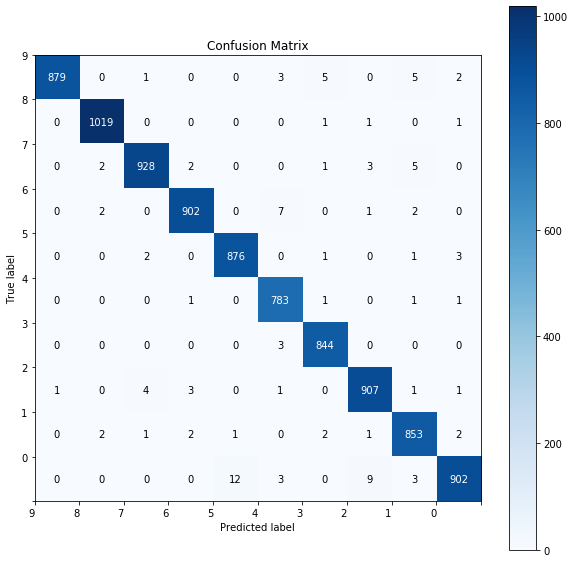

In [25]:
# test model
correct_count, all_count = 0, 0
predicted_labels = []
actual_labels = []

for images,labels in test_dataloader:
    result = model(images)
    
    _, predictions = torch.max(result, 1)
    predicted_labels = predicted_labels + predictions.tolist()
    actual_labels = actual_labels + labels.tolist()
    all_count += images.size(0)
    
label_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,]
plot_confusion_matrix(predicted_labels, actual_labels, label_list)

# Comparing results

# The Social, Economic and Societal Aspects of the work

The task of handwritten digit recognition can be used for online handwriting recognition on computer tablets, recognizing zip codes on mail for postal mail sorting, processing bank check amounts, numeric entries in forms filled up by hand (for example ‐ tax forms). People can write same digits in different ways such as digit 1 and 7 can be written as:

In [ ]:
display(HTML("<table><tr><td><img src='img/digit1and7part1.jpg'></td><td><img src='img/digit1and7part2.jpg'></td></tr></table>"))

The first image shows how people from English speaking countries write the digits whereas the second image shows how people from continental Europe write those digits [3]. 

A lot of times the prescription written by medical professionals are unreadable and only people who are part of the medical industry like pharmacists, chemists etc. Only they can understand the handwritten prescriptions of the doctors. This could be another use of the handwritten digit recognition. 

The handwritten digit recognition system could be expanded to recognize digits written in different writing systems for example in roman the digits are:

In [ ]:
display(HTML("<table><tr><td><img src='img/numbers1.jpg'></td></tr></table>"))

Whereas in Chinese(simple) the digits are written as:

In [ ]:
display(HTML("<table><tr><td><img src='img/numbers2.jpg'></td></tr></table>"))

The information about the different writing order can be found from [4].

# Challenges

During the project implementation, there were several challenges that the group had to face. Of the main challenges occured during the initial phase, where the group had to implement the simple neural network. Due to the fact that every group member had different experiences, it took some time to ensure that every member understand the concept behind neural networks. Only when that step was achieved, the group was able to create a simple neural network.

# References

[1] https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

[2] https://towardsdatascience.com/mnist-handwritten-digits-classification-using-a-convolutional-neural-network-cnn-af5fafbc35e9

[3] https://english.stackexchange.com/questions/62586/why-is-1-hand-written-without-a-serif-and-7-without-a-dash

[4] https://www.omniglot.com/language/numerals.htm